In [1]:
import itertools # 是 Python 的內建模組，提供了一組用於處理迭代器的函數和工具。
                 # 它包含了各種用於高效處理迭代器的函數，可以幫助我們編寫更簡潔、高效的代碼。
import sys # 是 Python 的內建模組，提供了與 Python 解釋器和運行環境相關的功能。
# sys.path 是一個列表，包含了 Python 解釋器在導入模組時會搜尋的路徑。
# 當你使用 import 語句導入模組時 Python 會依次在 sys.path 中的路徑下尋找對應的模組文件。
sys.path.append("../ecg-classification/")
# sys.path.append("C:\\Users\\Chen_Lab01\\Documents\\GitHub/ecg-classification")
# from IPython.display import Video
# import cv2
from matplotlib import pyplot as plt
plt.style.use("ggplot") #  是 Matplotlib 庫中用於設置繪圖樣式的函數。它使用了一種名為 "ggplot" 的預定義樣式
import matplotlib
matplotlib.use("TkAgg")
                        #  該樣式模仿了 R 語言的 ggplot2 繪圖包的外觀。
# print(sys.path)
from ecg_tools.config import EcgConfig, Mode
from ecg_tools.data_loader import DatasetConfig, get_data_loaders
from ecg_tools.model import ECGformer
from ecg_tools.train import ECGClassifierTrainer



## Data

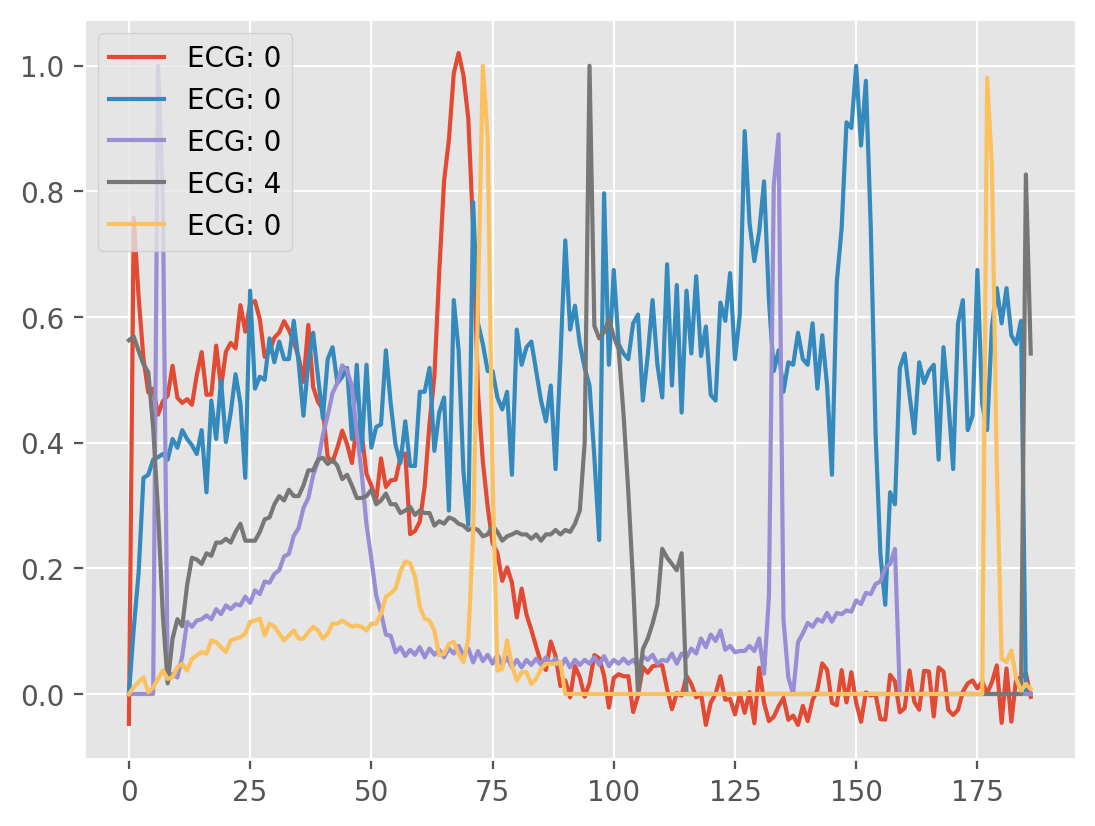

In [2]:
# 隨機抽 5 筆 ECG Data 出來觀察
NUM_EXAMPLES = 5
config = EcgConfig()
data_loaders = get_data_loaders(config.dataset)

plt.figure(1, dpi=200) # dpi 設置解析度
labels = []

for idx, data in enumerate(data_loaders[Mode.train]):
    if idx == NUM_EXAMPLES:
        break
    plt.plot(data[0][0, ...].squeeze().numpy())
    labels.append(int(data[1][0, ...].numpy()))

plt.legend([f"ECG: {label}" for label in labels])
%matplotlib inline
plt.show()

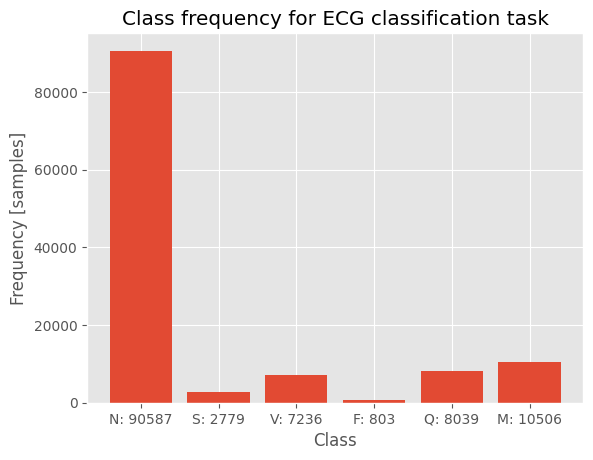

In [3]:
config = EcgConfig()
data_loaders = get_data_loaders(config.dataset)
classes = ["N", "S", "V", "F", "Q", "M"]
labels = {
    idx: 0 for idx in range(len(classes))
}

for data in itertools.chain(*list(data_loaders.values())):
    for label in data[1].numpy():
        labels[int(label)] += 1

plt.bar(range(len(classes)), list(labels.values()), tick_label=[f"{k}: {v}" for k, v in zip(classes, list(labels.values()))])
plt.title("Class frequency for ECG classification task")
plt.ylabel("Frequency [samples]")
plt.xlabel("Class")
%matplotlib inline
plt.show()

## Modeling

In [4]:
config = EcgConfig()
model = ECGformer(
    embed_size=config.model.embed_size,
    num_layers=config.model.num_layers,
    num_heads=config.model.num_heads,
    num_classes=config.model.num_classes,
    signal_length=config.model.signal_length,
    expansion=config.model.expansion,
    input_channels=config.model.input_channels
)
model
from torchinfo import summary
# input = (batch_size, signal_length, input_channels)
summary(model, input_size=(64, config.model.signal_length, 1),
       device='cpu',
       col_names=("input_size", "output_size", "num_params", "kernel_size"),
       depth=3) # depth = 3 表示只顯示到第三層
# print(model)




Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ECGformer                                          [64, 187, 1]              [64, 6]                   36,096                    --
├─LinearEmbedding: 1-1                             [64, 187, 1]              [64, 188, 192]            192                       --
│    └─Linear: 2-1                                 [64, 187, 1]              [64, 187, 192]            384                       --
│    └─LayerNorm: 2-2                              [64, 187, 192]            [64, 187, 192]            384                       --
│    └─GELU: 2-3                                   [64, 187, 192]            [64, 187, 192]            --                        --
├─ModuleList: 1-2                                  --                        --                        --                        --
│    └─TransformerEncoderLayer: 2-4                [64, 188, 192] 

### Quantization Test

In [5]:
import torch.quantization
model(torch.randn(1, config.model.signal_length, 1)).shape

# 使用 Eager Mode Quantization
# 將 torch.nn.Linear 的參數映射到 -127~127 之間
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

quantized_model
from torchinfo import summary
summary(quantized_model, input_size=(64, config.model.signal_length, 1),
       device='cpu',
       col_names=("input_size", "output_size", "num_params", "kernel_size"),
       depth=5) # depth = 3 表示只顯示到第三層
# print(model)


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
ECGformer                                          [64, 187, 1]              [64, 6]                   36,096                    --
├─LinearEmbedding: 1-1                             [64, 187, 1]              [64, 188, 192]            192                       --
│    └─Linear: 2-1                                 [64, 187, 1]              [64, 187, 192]            --                        --
│    └─LayerNorm: 2-2                              [64, 187, 192]            [64, 187, 192]            384                       --
│    └─GELU: 2-3                                   [64, 187, 192]            [64, 187, 192]            --                        --
├─ModuleList: 1-2                                  --                        --                        --                        --
│    └─TransformerEncoderLayer: 2-4                [64, 188, 192] 

### Model ParameterTest

In [6]:
for name in quantized_model.state_dict():
   print(name)

print(quantized_model.state_dict()['encoder.0.0.block.1.queries_projection._packed_params._packed_params'])

positional_encoding
encoder.0.0.block.0.weight
encoder.0.0.block.0.bias
encoder.0.0.block.1.queries_projection.scale
encoder.0.0.block.1.queries_projection.zero_point
encoder.0.0.block.1.queries_projection._packed_params.dtype
encoder.0.0.block.1.queries_projection._packed_params._packed_params
encoder.0.0.block.1.values_projection.scale
encoder.0.0.block.1.values_projection.zero_point
encoder.0.0.block.1.values_projection._packed_params.dtype
encoder.0.0.block.1.values_projection._packed_params._packed_params
encoder.0.0.block.1.keys_projection.scale
encoder.0.0.block.1.keys_projection.zero_point
encoder.0.0.block.1.keys_projection._packed_params.dtype
encoder.0.0.block.1.keys_projection._packed_params._packed_params
encoder.0.0.block.1.final_projection.scale
encoder.0.0.block.1.final_projection.zero_point
encoder.0.0.block.1.final_projection._packed_params.dtype
encoder.0.0.block.1.final_projection._packed_params._packed_params
encoder.0.1.block.0.weight
encoder.0.1.block.0.bias
enco

### Visualize Model

In [8]:
quantized_model.eval()
inputs = torch.randn(1, 187, 1)
traced_script_module = torch.jit.trace(quantized_model, inputs)
traced_script_module.save("traced_resnet_model.pth")

from torchviz import make_dot
vis_graph = make_dot(quantized_model(inputs), params=dict(quantized_model.named_parameters()), show_attrs=True, show_saved=True)
vis_graph.view()  # 会在当前目录下保存一个“Digraph.gv.pdf”文件，并在默认浏览器中打开

import netron
modelData = 'traced_resnet_model.pth'
netron.start(modelData)

Serving 'traced_resnet_model.pth' at http://localhost:8080


('localhost', 8080)

## Training

TRAINING: 0, loss: 0.8008654117584229. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:40<00:00, 15.00it/s] 


TRAINING Accuracy: 0.785770833492279
[[69760   195   892    94  1340   189]
 [ 1969   157    46     2    44     5]
 [ 3835    65  1165    26   675    22]
 [  592     4    10    33     1     1]
 [ 2049     6   201     1  4147    27]
 [ 7562    24   301     8   338   172]]
epoch_loss: 0.0005339102745056152


VALIDATION: 0, loss: 1.5842394828796387. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [0, 0, 5, 5, 0, 5, 0, 0]: 100%|██████████| 375/375 [00:08<00:00, 44.66it/s] 


VALIDATION Accuracy: 0.8577916622161865
[[17863    47    45    13    49   100]
 [  281   252    17     0     3     3]
 [  507    45   773    37    78     8]
 [  114     0     4    44     0     0]
 [  166     0     8     0  1403    31]
 [ 1752    19    61     0    17   252]]


TRAINING: 1, loss: 0.4908685088157654. Target: [0, 0, 0, 4, 0, 0, 2, 0], Prediction: [0, 5, 0, 4, 0, 0, 2, 0]: 100%|██████████| 1500/1500 [01:32<00:00, 16.26it/s] 


TRAINING Accuracy: 0.8354062438011169
[[68807   595   838   396   475  1359]
 [ 1207   843   105     2    21    45]
 [ 1770   154  3307    94   321   142]
 [  387     5    22   225     0     2]
 [  617    20   174     3  5475   142]
 [ 6317    82   291    16   157  1542]]
epoch_loss: 0.0003272456725438436


TRAINING: 2, loss: 0.42381617426872253. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:31<00:00, 16.37it/s]


TRAINING Accuracy: 0.8545312285423279
[[68756   585   682   391   377  1679]
 [ 1029   998   106     6    13    71]
 [ 1371   114  3876   108   178   141]
 [  319     6    30   281     0     5]
 [  485    11   100     2  5685   148]
 [ 5494    73   240    20   139  2439]]
epoch_loss: 0.00028254411617914836


VALIDATION: 2, loss: 0.9357717037200928. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:08<00:00, 44.75it/s] 


VALIDATION Accuracy: 0.8891249895095825
[[17348   194    94   137    13   331]
 [  204   331    11     1     0     9]
 [  239    53  1073    62     5    16]
 [   47     0     3   112     0     0]
 [  105     5    15     1  1436    46]
 [ 1010     9    34     4     5  1039]]


TRAINING: 3, loss: 0.19157320261001587. Target: [0, 0, 0, 0, 4, 2, 0, 0], Prediction: [0, 0, 0, 0, 4, 0, 0, 0]: 100%|██████████| 1500/1500 [01:31<00:00, 16.31it/s]


TRAINING Accuracy: 0.8658437132835388
[[68606   619   591   344   355  1955]
 [  922  1123    81     1    20    76]
 [ 1063   106  4198   119   149   153]
 [  290     4    36   309     0     2]
 [  424     9   102     4  5741   151]
 [ 4848    81   199    24   109  3144]]
epoch_loss: 0.00012771546840667725


TRAINING: 4, loss: 0.6867583990097046. Target: [0, 0, 0, 0, 1, 2, 0, 4], Prediction: [0, 0, 0, 0, 1, 2, 0, 4]: 100%|██████████| 1500/1500 [01:31<00:00, 16.41it/s] 


TRAINING Accuracy: 0.8740520477294922
[[68579   594   577   370   293  2057]
 [  869  1187    83     5    15    64]
 [  901    83  4363   136   127   178]
 [  267     4    42   320     1     7]
 [  351     8    73     2  5857   140]
 [ 4412    76   181    21   112  3603]]
epoch_loss: 0.0004578389326731364


VALIDATION: 4, loss: 0.46982842683792114. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 0, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:08<00:00, 45.36it/s] 


VALIDATION Accuracy: 0.9004166722297668
[[17021    92   105    52    30   817]
 [  186   307    30     1     3    29]
 [  128    10  1196    41    23    50]
 [   40     0    12   108     1     1]
 [   76     0     5     0  1499    28]
 [  565     3    26     4    24  1479]]


TRAINING: 5, loss: 0.9353039264678955. Target: [1, 5, 0, 0, 0, 2, 0, 5], Prediction: [0, 0, 0, 0, 0, 2, 0, 0]: 100%|██████████| 1500/1500 [01:30<00:00, 16.51it/s] 


TRAINING Accuracy: 0.8777916431427002
[[68393   619   604   342   312  2200]
 [  835  1228    75     2    14    69]
 [  791    94  4469   140   113   181]
 [  253     4    41   337     1     5]
 [  347     8    90     3  5852   131]
 [ 4033    72   196    32    83  3989]]
epoch_loss: 0.000623535950978597


TRAINING: 6, loss: 1.194775938987732. Target: [0, 0, 5, 0, 0, 5, 2, 0], Prediction: [0, 0, 5, 0, 0, 5, 0, 0]: 100%|██████████| 1500/1500 [01:29<00:00, 16.79it/s]  


TRAINING Accuracy: 0.8817395567893982
[[68362   643   556   358   291  2260]
 [  777  1266    84     6    18    72]
 [  737    69  4541   139   107   195]
 [  221     5    53   355     0     7]
 [  336     3    72     1  5890   129]
 [ 3804    88   170    18    92  4233]]
epoch_loss: 0.000796517292658488


VALIDATION: 6, loss: 0.547340452671051. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:08<00:00, 46.69it/s]   


VALIDATION Accuracy: 0.906333327293396
[[16926   372   242    86    57   434]
 [  155   381    12     0     1     7]
 [   77    20  1275    46    11    19]
 [   36     0    11   115     0     0]
 [   56     0     7     0  1526    19]
 [  458    17    70     2    25  1529]]


TRAINING: 7, loss: 0.9849861264228821. Target: [0, 0, 0, 0, 5, 0, 0, 4], Prediction: [0, 0, 0, 0, 5, 0, 0, 4]: 100%|██████████| 1500/1500 [01:29<00:00, 16.83it/s] 


TRAINING Accuracy: 0.8880937695503235
[[68402   612   553   356   279  2268]
 [  757  1306    70     2    15    73]
 [  705    67  4625   145    84   162]
 [  222     3    39   369     0     8]
 [  358     1    73     3  5878   118]
 [ 3395    70   127    24   112  4677]]
epoch_loss: 0.0006566574176152547


TRAINING: 8, loss: 0.13352766633033752. Target: [0, 0, 0, 5, 0, 0, 0, 5], Prediction: [0, 0, 0, 5, 0, 0, 0, 5]: 100%|██████████| 1500/1500 [01:28<00:00, 16.90it/s]


TRAINING Accuracy: 0.8929062485694885
[[68487   647   540   329   270  2197]
 [  735  1326    72     6    15    69]
 [  645    67  4666   137   107   166]
 [  204     5    36   381     1    14]
 [  324     7    63     0  5932   105]
 [ 3186    68   124    17    83  4927]]
epoch_loss: 8.901844422022501e-05


VALIDATION: 8, loss: 0.353707492351532. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:08<00:00, 43.74it/s]  


VALIDATION Accuracy: 0.9305416345596313
[[17441    43   108    25    10   490]
 [  200   331    11     0     1    13]
 [  107    12  1261    28     5    35]
 [   42     0    17   101     0     2]
 [   86     0    12     0  1477    33]
 [  363     2     5     0     9  1722]]


TRAINING: 9, loss: 0.3961936831474304. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:35<00:00, 15.66it/s] 


TRAINING Accuracy: 0.8947083353996277
[[68343   649   551   330   293  2304]
 [  714  1363    65     5    15    61]
 [  631    64  4710   133    93   157]
 [  207     6    36   379     0    13]
 [  335     3    66     0  5924   103]
 [ 2946    59   118    26    83  5173]]
epoch_loss: 0.00026412912209828693


TRAINING: 10, loss: 0.6377089023590088. Target: [0, 5, 0, 0, 0, 5, 0, 0], Prediction: [0, 5, 5, 0, 0, 0, 0, 1]: 100%|██████████| 1500/1500 [01:35<00:00, 15.64it/s] 


TRAINING Accuracy: 0.8997291326522827
[[68530   630   532   319   260  2199]
 [  669  1395    70     2    15    72]
 [  611    54  4771   117    85   150]
 [  205     4    41   379     0    12]
 [  326     5    56     0  5953    91]
 [ 2772    65   111    31    80  5346]]
epoch_loss: 0.0004251392682393392


VALIDATION: 10, loss: 0.37309521436691284. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:08<00:00, 43.44it/s] 


VALIDATION Accuracy: 0.9325000047683716
[[17502   108    63    79     8   357]
 [  163   342    33     1     1    16]
 [   97     5  1250    57     3    36]
 [   27     0    10   125     0     0]
 [   95     0     6     0  1464    43]
 [  389     4     5     2     4  1697]]


TRAINING: 11, loss: 0.24764318764209747. Target: [0, 5, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:36<00:00, 15.61it/s]


TRAINING Accuracy: 0.903208315372467
[[68660   617   485   320   242  2146]
 [  668  1416    60     2    13    64]
 [  588    56  4805   113    97   129]
 [  178     5    40   400     0    18]
 [  297     4    56     0  5976    98]
 [ 2684    65   108    24    73  5451]]
epoch_loss: 0.000165095458428065


TRAINING: 12, loss: 0.13227450847625732. Target: [0, 0, 2, 0, 4, 0, 0, 0], Prediction: [0, 0, 2, 0, 4, 0, 0, 0]: 100%|██████████| 1500/1500 [01:35<00:00, 15.77it/s]


TRAINING Accuracy: 0.9041354060173035
[[68614   623   493   298   244  2198]
 [  692  1410    61     1    10    49]
 [  557    53  4866   109    79   124]
 [  181     8    48   393     0    11]
 [  316     2    68     1  5954    90]
 [ 2618    50    91    20    66  5560]]
epoch_loss: 8.818300565083822e-05


VALIDATION: 12, loss: 0.4667612910270691. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:08<00:00, 44.33it/s]  


VALIDATION Accuracy: 0.9417083263397217
[[17673   121   139    16    29   139]
 [  170   372    11     0     0     3]
 [   97    12  1301    19    11     8]
 [   41     0    19   100     0     2]
 [   59     0     6     0  1534     9]
 [  427     7    18     1    27  1621]]


TRAINING: 13, loss: 0.30080854892730713. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 5, 0, 5, 0, 0]: 100%|██████████| 1500/1500 [01:35<00:00, 15.78it/s]


TRAINING Accuracy: 0.906749963760376
[[68680   610   497   277   245  2161]
 [  656  1430    60     1    15    61]
 [  571    60  4845   108    78   126]
 [  180     2    50   395     0    14]
 [  317     3    50     2  5979    80]
 [ 2452    42   108    19    65  5719]]
epoch_loss: 0.00020053903261820475


TRAINING: 14, loss: 0.5348559617996216. Target: [0, 4, 0, 0, 0, 0, 5, 0], Prediction: [0, 4, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:35<00:00, 15.63it/s] 


TRAINING Accuracy: 0.9076458215713501
[[68742   603   490   295   230  2110]
 [  654  1425    60     5    13    66]
 [  563    71  4825   123    80   126]
 [  167     3    51   404     0    16]
 [  283     4    64     0  5987    93]
 [ 2413    55   105    14    67  5751]]
epoch_loss: 0.0003565706411997477


VALIDATION: 14, loss: 0.5213786363601685. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 0, 5, 5, 5]: 100%|██████████| 375/375 [00:08<00:00, 44.08it/s]  


VALIDATION Accuracy: 0.9402499794960022
[[17681   134    87    22    60   133]
 [  170   374     9     0     1     2]
 [  105    19  1251    35    15    23]
 [   34     0    10   116     1     1]
 [   40     0     2     0  1555    11]
 [  462    11     7     0    32  1589]]


TRAINING: 15, loss: 0.49789857864379883. Target: [0, 0, 0, 0, 0, 2, 0, 0], Prediction: [0, 5, 0, 5, 0, 2, 0, 5]: 100%|██████████| 1500/1500 [01:35<00:00, 15.65it/s]


TRAINING Accuracy: 0.9086458086967468
[[68684   636   470   282   242  2156]
 [  623  1477    43     0    11    69]
 [  575    47  4872   100    61   133]
 [  171     2    51   407     0    10]
 [  277     1    49     1  6022    81]
 [ 2387    59    99    15    77  5768]]
epoch_loss: 0.00033193238576253255


TRAINING: 16, loss: 0.14750617742538452. Target: [5, 0, 4, 0, 0, 0, 0, 0], Prediction: [5, 0, 4, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:34<00:00, 15.84it/s]


TRAINING Accuracy: 0.9142916798591614
[[68955   564   485   276   214  1976]
 [  631  1473    48     4    12    55]
 [  529    59  4908   105    66   121]
 [  167     4    46   414     0    10]
 [  266     2    56     0  6027    80]
 [ 2188    55    84    17    66  5995]]
epoch_loss: 9.833745161692302e-05


VALIDATION: 16, loss: 0.15125207602977753. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:08<00:00, 43.71it/s] 


VALIDATION Accuracy: 0.9385833144187927
[[17395    62   139    20   102   399]
 [  176   350    18     0     2    10]
 [   81    23  1275    31     5    33]
 [   44     0    14   102     1     1]
 [   25     0     7     0  1559    17]
 [  217     1    17     0    21  1845]]


TRAINING: 17, loss: 0.23091109097003937. Target: [2, 5, 0, 0, 0, 1, 0, 0], Prediction: [2, 5, 0, 0, 0, 1, 0, 0]: 100%|██████████| 1500/1500 [01:34<00:00, 15.82it/s]


TRAINING Accuracy: 0.9135416746139526
[[68920   561   462   270   235  2022]
 [  643  1449    53     1     8    69]
 [  526    50  4919   100    79   114]
 [  165     3    42   419     1    11]
 [  272     1    57     0  6010    91]
 [ 2201    49    84    15    73  5983]]
epoch_loss: 0.00015394072731335958


TRAINING: 18, loss: 0.5011262893676758. Target: [0, 0, 2, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:35<00:00, 15.75it/s] 


TRAINING Accuracy: 0.9165208339691162
[[69041   542   473   269   225  1920]
 [  607  1491    45     2     8    70]
 [  528    45  4918    98    74   125]
 [  161     4    43   423     0    10]
 [  261     5    63     0  6021    81]
 [ 2098    42    81    17    75  6092]]
epoch_loss: 0.00033408419291178383


VALIDATION: 18, loss: 0.2336772382259369. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:08<00:00, 44.30it/s]  


VALIDATION Accuracy: 0.9473749995231628
[[17714    65    36    20    11   271]
 [  168   362     5     0     0    21]
 [  121    27  1237    38     5    20]
 [   41     0     7   110     0     4]
 [   63     0     5     0  1516    24]
 [  278     1    10     0    14  1798]]


TRAINING: 19, loss: 0.8368993401527405. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:34<00:00, 15.85it/s] 


TRAINING Accuracy: 0.9167812466621399
[[69034   541   442   282   234  1937]
 [  637  1478    41     1    11    55]
 [  538    58  4917    94    70   111]
 [  162     2    46   417     1    13]
 [  276     1    61     0  6009    84]
 [ 2021    39    99    20    70  6156]]
epoch_loss: 0.0005579328934351603


TRAINING: 20, loss: 0.14532066881656647. Target: [0, 0, 0, 0, 0, 0, 0, 0], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:36<00:00, 15.60it/s]


TRAINING Accuracy: 0.9178957939147949
[[69068   544   450   276   219  1913]
 [  601  1484    60     1    14    63]
 [  514    61  4946    93    57   117]
 [  154     5    49   418     0    15]
 [  249     3    47     0  6052    80]
 [ 2041    49    95    14    56  6150]]
epoch_loss: 9.688044587771098e-05


VALIDATION: 20, loss: 0.4138968586921692. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:08<00:00, 43.46it/s]   


VALIDATION Accuracy: 0.9513750076293945
[[17796    49    61    36    35   140]
 [  184   364     3     1     2     2]
 [   95    12  1278    43     4    16]
 [   28     0     7   125     1     1]
 [   39     0     4     0  1555    10]
 [  342     1    17     7    19  1715]]


TRAINING: 21, loss: 0.141386941075325. Target: [0, 0, 0, 0, 4, 0, 0, 0], Prediction: [0, 0, 0, 0, 4, 0, 0, 0]: 100%|██████████| 1500/1500 [01:34<00:00, 15.84it/s]  


TRAINING Accuracy: 0.9191041588783264
[[69087   569   438   227   213  1936]
 [  618  1488    55     2    14    46]
 [  520    56  4951    88    65   108]
 [  149     1    44   437     1     9]
 [  271     3    42     0  6036    79]
 [ 1962    38   102    15    53  6235]]
epoch_loss: 9.425796071688334e-05


TRAINING: 22, loss: 0.1713562309741974. Target: [0, 0, 0, 5, 0, 0, 0, 5], Prediction: [0, 0, 0, 5, 0, 0, 0, 5]: 100%|██████████| 1500/1500 [01:34<00:00, 15.82it/s] 


TRAINING Accuracy: 0.9165520668029785
[[68972   563   483   289   229  1934]
 [  600  1495    58     0    13    57]
 [  540    60  4918    94    68   108]
 [  170     1    46   411     0    13]
 [  267     3    59     0  6016    86]
 [ 2027    54    81    12    54  6177]]
epoch_loss: 0.00011423748731613159


VALIDATION: 22, loss: 0.187454953789711. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:08<00:00, 43.98it/s]   


VALIDATION Accuracy: 0.9411666393280029
[[17429    92    34    48    17   497]
 [  151   380     6     0     0    19]
 [   94    18  1246    35    10    45]
 [   26     0     9   123     0     4]
 [   70     0     4     0  1506    28]
 [  180     0     6     0    11  1904]]


TRAINING: 23, loss: 0.1109345406293869. Target: [0, 5, 0, 5, 0, 5, 0, 0], Prediction: [0, 5, 0, 5, 0, 5, 0, 0]: 100%|██████████| 1500/1500 [01:35<00:00, 15.78it/s] 


TRAINING Accuracy: 0.9212812185287476
[[69117   533   446   265   222  1887]
 [  607  1504    50     0     9    53]
 [  477    54  5001    94    46   116]
 [  158     2    43   424     0    14]
 [  252     2    50     0  6048    79]
 [ 1841    35    96    17    67  6349]]
epoch_loss: 7.395636041959126e-05


TRAINING: 24, loss: 0.4322769343852997. Target: [0, 0, 0, 0, 0, 5, 1, 0], Prediction: [0, 0, 0, 0, 0, 5, 1, 0]: 100%|██████████| 1500/1500 [01:34<00:00, 15.92it/s] 


TRAINING Accuracy: 0.9228854179382324
[[69230   556   431   247   215  1791]
 [  598  1511    53     0     8    53]
 [  511    50  4969    77    67   114]
 [  142     5    43   437     1    13]
 [  241     2    53     1  6065    69]
 [ 1811    39   106    15    49  6385]]
epoch_loss: 0.0002881846229235331


VALIDATION: 24, loss: 0.24692629277706146. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:08<00:00, 44.20it/s] 


VALIDATION Accuracy: 0.953249990940094
[[17668   144    87    31    19   168]
 [  151   392     8     1     1     3]
 [   72    12  1305    36     7    16]
 [   27     1    10   122     0     2]
 [   37     1     4     0  1550    16]
 [  233     1    15     0    11  1841]]


TRAINING: 25, loss: 0.4253549575805664. Target: [0, 0, 0, 0, 0, 0, 0, 5], Prediction: [0, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:34<00:00, 15.87it/s] 


TRAINING Accuracy: 0.9210729002952576
[[69090   574   474   272   225  1835]
 [  590  1508    44     1    12    68]
 [  490    55  4978    95    55   115]
 [  144     3    46   431     2    15]
 [  248     6    54     1  6047    75]
 [ 1850    39    75    12    60  6369]]
epoch_loss: 0.0002835699717203776


TRAINING: 26, loss: 0.11582116782665253. Target: [4, 0, 3, 0, 4, 0, 0, 0], Prediction: [4, 0, 3, 0, 4, 0, 0, 0]: 100%|██████████| 1500/1500 [01:34<00:00, 15.85it/s] 


TRAINING Accuracy: 0.9246562123298645
[[69285   554   409   239   213  1770]
 [  571  1549    43     1     8    51]
 [  499    52  4992    83    53   109]
 [  131     3    54   434     0    19]
 [  231     1    49     0  6076    74]
 [ 1786    37    81    15    55  6431]]
epoch_loss: 7.721411188443502e-05


VALIDATION: 26, loss: 0.25442513823509216. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:08<00:00, 43.93it/s] 


VALIDATION Accuracy: 0.9442083239555359
[[17382   163   105    98    28   341]
 [  131   400    14     2     1     8]
 [   52     3  1297    60     8    28]
 [   18     0     6   136     0     2]
 [   25     0    10     1  1553    19]
 [  166     5    12    15    10  1893]]


TRAINING: 27, loss: 0.5235822200775146. Target: [0, 0, 0, 0, 0, 4, 0, 2], Prediction: [0, 0, 0, 0, 0, 4, 0, 2]: 100%|██████████| 1500/1500 [01:37<00:00, 15.41it/s]  


TRAINING Accuracy: 0.9250208139419556
[[69275   573   451   265   197  1709]
 [  569  1544    45     2    13    50]
 [  492    51  5012    87    58    88]
 [  141     2    43   443     0    12]
 [  238     2    54     1  6061    75]
 [ 1742    39    77    16    64  6467]]
epoch_loss: 0.00034905481338500975


TRAINING: 28, loss: 0.5035697817802429. Target: [0, 0, 0, 0, 0, 5, 0, 0], Prediction: [3, 0, 0, 0, 0, 0, 0, 0]: 100%|██████████| 1500/1500 [01:37<00:00, 15.32it/s] 


TRAINING Accuracy: 0.924916684627533
[[69198   590   470   257   193  1762]
 [  588  1529    37     1    14    54]
 [  446    51  5045    84    67    95]
 [  141     4    45   440     1    10]
 [  228     5    53     0  6064    81]
 [ 1696    43    81    14    55  6516]]
epoch_loss: 0.00033571318785349525


VALIDATION: 28, loss: 0.3056107759475708. Target: [5, 5, 5, 5, 5, 5, 5, 5], Prediction: [5, 5, 5, 5, 5, 5, 5, 5]: 100%|██████████| 375/375 [00:08<00:00, 42.80it/s]  


VALIDATION Accuracy: 0.9474999904632568
[[17582   204    84    40    31   176]
 [  131   401    16     1     2     5]
 [   72    19  1287    38    10    22]
 [   24     0     9   129     0     0]
 [   34     0     9     0  1553    12]
 [  260    16    21     1    15  1788]]


TRAINING: 29, loss: 0.2019592970609665. Target: [1, 0, 4, 0, 0, 4, 4, 0], Prediction: [1, 5, 4, 0, 0, 4, 4, 0]:  39%|███▊      | 578/1500 [00:37<00:59, 15.37it/s] 


KeyboardInterrupt: 

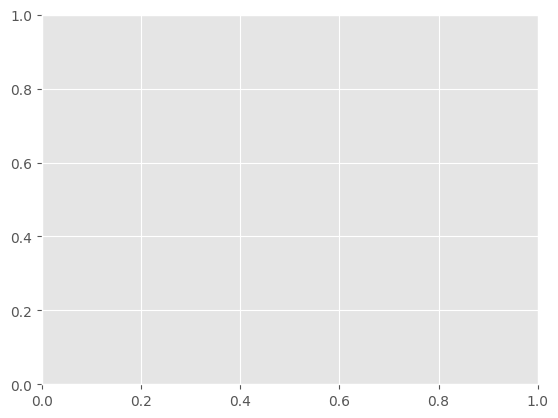

In [9]:
config = EcgConfig()
trainer = ECGClassifierTrainer(config)

train_confusion_matrix, eval_confusion_matrix, epoch_loss = trainer.train()

## Evaluating

In [ ]:
# plot loss
plt.figure(1, dpi=200)
plt.plot(epoch_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
%matplotlib inline
plt.show()

In [ ]:
# Confusion matrix
plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.imshow(train_confusion_matrix[0])
plt.title("Training Confusion Matrix")


plt.subplot(1, 2, 2)
plt.imshow(eval_confusion_matrix[-1])
plt.title("Validation Confusion Matrix")

plt.tight_layout()
plt.show()


### Save model and load model

In [ ]:
import torch
torch.save(model, "..\\model_save\\model.pth")
model_test = torch.load("..\\model_save\\model.pth")
print(model_test)